# Prediction of Liver Transplantation Success Rate

Team: Liver Longer

## 1. Introduction

### 1.1 Helper Fuctions & Libraries

In [98]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def showPearsonCorr(df):
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(9, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(df, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def showBarChart(data, x_label, y_label, x_names):
    plt.figure(figsize=(13,6))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(range(len(x_names)),x_names, rotation=80)
    plt.bar(range(len(x_names)), data )  
    plt.show() 
    
def getMissingRate(data):
    result=pd.DataFrame( data.isnull().sum()/len(data)*100 )
    result.columns=["MissingRate"]
    result=result[result["MissingRate"]>0]
    return result

def getXandY(df, day, PorG):
    if PorG=="PTIME":
        tmp=df[ (df.PTIME>=day) | (df.PSTATUS==1) ].copy()
        tmp.loc[: , "label"]= tmp.apply(lambda x: x.PIME<day, axis=1).astype(int)
        tmp.drop( columns=["GTIME", "GSTATUS"], inplace=True )
        tmp.drop( columns=["PTIME", "PSTATUS"], inplace=True )
        y=tmp.label
        x=tmp.iloc[:,:-1]
        return x,y
    elif PorG=="GTIME":
        tmp=df[(df.GTIME>=day) | (df.GSTATUS==1) ].copy()
        tmp.loc[:, "label"] = tmp.apply(lambda x: x.GTIME<day, axis=1).astype(int)
        tmp.drop(columns=["GTIME", "GSTATUS"], inplace=True)
        tmp.drop(columns=["PTIME", "PSTATUS"], inplace=True)
        y=tmp.label
        x=tmp.iloc[:,:-1]
        return x,y
    else:
        return None, None
    
def plotFeatureImportance(xgbModel, importanceType="weight", featureNum=80):
    tmp=xgbModel.get_score(importance_type=importanceType)
    kv=list(tmp.items())
    kv.sort(key=lambda x: -x[1])
    kv=kv[:featureNum]
    kv=list(zip(*kv))
    names=kv[0]
    values=kv[1]
    plt.figure(figsize=(20,10))
    plt.xlabel("Feature")
    plt.ylabel(importanceType)
    plt.xticks(range(len(names)),names, rotation=80)
    plt.bar(range(len(names)), values )  
    plt.show() 
    
    
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### 1.2 Load Data

In [2]:
data = pd.read_csv('dataset/liver_data_inf560.csv',header = 0, na_values = 'NaN')

### 1.3 Data Preprocessing

illegal features

In [3]:
data= data.drop(data[data.PTIME < data.GTIME].index)
tmp= data.drop(data[data["FINAL_MELD_OR_PELD"]=="PELD"].index )
tmp= tmp.drop(columns=["FINAL_MELD_OR_PELD"])
data= tmp
originalData=data.copy()

In [4]:
tmp= data.replace("Unknown", np.nan)

#### Drop post transplant features 

In [5]:
allPostFeatures=["BILIARY", "COD","COD_OSTXT","COD2","COD2_OSTXT","COD3","COD3_OSTXT","GRF_FAIL_CAUSE_OSTXT","GRF_STAT",
              "HEP_DENOVO",
              "HEP_RECUR",
              "INFECT",
              "PRI_GRF_FAIL",
              "RECUR_DISEASE",
              "REJ_ACUTE",
              "VASC_THROMB",
              "FUNC_STAT_TRF",
              "PX_NON_COMPL",
              "REJ_CHRONIC",
              "DIFFUSE_CHOLANG",
              "HEPATIC_ART_THROM",
              "HEPATIC_OUT_OBS",
              "OTHER_VASC_THROMB",
              "PORTAL_VEIN_THROM",
              "PRI_NON_FUNC",
              "PX_STAT",
              "LOS",
              "ACUTE_REJ_EPI",
              "DIS_ALKPHOS",
              "DIS_SGOT",
              "COMPOSITE_DEATH_DATE",
              "DEATH_DATE",
              "DISCHARGE_DATE",
              "GRF_FAIL_DATE",
              "END_DATE"] 

postFeatures=[]
allFeatures=data.columns.values
for each in allPostFeatures:
    if each in allFeatures:
        postFeatures.append(each)

#["ACUTE_REJ_EPI", "GRF_STAT", "LOS"]

unrelatedFeatures=["WL_ID_CODE","DONOR_ID", "TRR_ID_CODE","CTR_CODE","OPO_CTR_CODE", "TRR_ID_CODE", "LISTING_CTR_CODE"]
                   # ["DATA_WAITLIST", "DATA_TRANSPLANT", "LT_ONE_WEEK_DON", "TX_MELD", "LIST_MELD"]
data.drop(columns=unrelatedFeatures, inplace=True)
# LOS: RECIPIENT LENGTH OF STAY POST TX
data.drop(columns=postFeatures, inplace=True)

### encode categorical features

In [6]:
categoricalFeatures=data.select_dtypes(include=["object"]).columns
singleValueFeatures=[]
tooManyCategories=[]
for feature in categoricalFeatures:
    num=data[feature].nunique()
    if num==2:
        mid=pd.get_dummies(data, columns=[feature], drop_first=True)
        mid.loc[data[feature].isnull(), mid.columns.str.startswith(feature)]=np.nan
        data=mid
    elif num==1:
        singleValueFeatures.append(feature)
    elif num>=3 and num<=10:
        data=pd.get_dummies(data, columns=[feature], dummy_na=True)
    else:
        tooManyCategories.append(feature)

### drop single value features

In [7]:
singleValueFeatures=[]
for feature in data.columns.values:
    num=data[feature].nunique()
    if num==1:
        singleValueFeatures.append(feature)
        
data.drop(columns=singleValueFeatures, inplace=True)

In [8]:
singleValueFeatures

['LIST_MELD',
 'TX_MELD',
 'LT_ONE_WEEK_DON',
 'DATA_TRANSPLANT',
 'DATA_WAITLIST',
 'ABO_nan',
 'EXC_HCC_nan',
 'FINAL_DIALYSIS_PRIOR_WEEK_nan',
 'ABO_DON_nan',
 'MALIG_nan']

### transform other features

e:\anaconda\envs\default\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


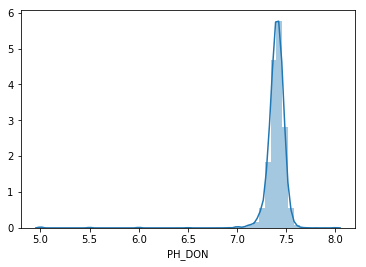

In [9]:
sns.distplot(data[data.PH_DON.notnull()].PH_DON)

In [10]:
data.loc[np.abs(data.PH_DON- data.PH_DON.mean())>(3*data.PH_DON.std()), "PH_DON"]=np.nan

### process nan

In [11]:
data=data.replace(999, np.nan)
data=data.replace(998, np.nan)
data=data.replace(997, np.nan)
data=data.replace(996, np.nan)

DIAG (May use binary encoding instead) 

In [12]:
categoricalNumeric=["DIAB"]
             # ["DIAG","LITYP"]

for each in categoricalNumeric:  
    data=pd.get_dummies(data, columns=[each], dummy_na=True)

FUNC_STAT_TRR

In [13]:
# column_name = 'FUNC_STAT_TRR'
# df = data
# df.loc[df.FUNC_STAT_TRR == 1.0, column_name] = 10
# df.loc[df.FUNC_STAT_TRR == 2.0, column_name] = 5
# df.loc[df.FUNC_STAT_TRR == 3.0, column_name] = 1
# df.loc[df.FUNC_STAT_TRR == 2010, column_name] = 1
# df.loc[df.FUNC_STAT_TRR == 2020, column_name] = 2
# df.loc[df.FUNC_STAT_TRR == 2030, column_name] = 3
# df.loc[df.FUNC_STAT_TRR == 2040, column_name] = 4
# df.loc[df.FUNC_STAT_TRR == 2050, column_name] = 5
# df.loc[df.FUNC_STAT_TRR == 2060, column_name] = 6
# df.loc[df.FUNC_STAT_TRR == 2070, column_name] = 7
# df.loc[df.FUNC_STAT_TRR == 2080, column_name] = 8
# df.loc[df.FUNC_STAT_TRR == 2090, column_name] = 9
# df.loc[df.FUNC_STAT_TRR == 2100, column_name] = 10
# df.loc[df.FUNC_STAT_TRR == 4010, column_name] = 1
# df.loc[df.FUNC_STAT_TRR == 4020, column_name] = 2
# df.loc[df.FUNC_STAT_TRR == 4030, column_name] = 3
# df.loc[df.FUNC_STAT_TRR == 4040, column_name] = 4
# df.loc[df.FUNC_STAT_TRR == 4050, column_name] = 5
# df.loc[df.FUNC_STAT_TRR == 4060, column_name] = 6
# df.loc[df.FUNC_STAT_TRR == 4070, column_name] = 7
# df.loc[df.FUNC_STAT_TRR == 4080, column_name] = 8
# df.loc[df.FUNC_STAT_TRR == 4090, column_name] = 9
# df.loc[df.FUNC_STAT_TRR == 4100, column_name] = 10
# data = df

In [14]:
data.TX_PROCEDUR_TY=data.TX_PROCEDUR_TY-700

In [15]:
data.shape


(39539, 317)

### 1.3 Dataset Structure & Content

In [16]:
data.describe()

,NUM_PREV_TX,EDUCATION,REM_CD,DAYSWAIT_CHRON,END_STAT,ETHNICITY,ETHCAT,END_BMI_CALC,REGION,FINAL_ALBUMIN,...,HISTORY_MI_DON_U,HISTORY_MI_DON_Y,HISTORY_MI_DON_nan,CORONARY_ANGIO_DON_Y,DIAB_1.0,DIAB_2.0,DIAB_3.0,DIAB_4.0,DIAB_5.0,DIAB_nan
count,39539.000000,31959.000000,39539.000000,39528.000000,39539.000000,39539.000000,39539.000000,39517.000000,39539.000000,39538.000000,...,39539.000000,39539.000000,39539.000000,36503.000000,39539.000000,39539.000000,39539.000000,39539.000000,39539.000000,39539.000000
mean,0.077367,3.693795,4.571992,207.522440,6210.982245,0.138926,1.790890,28.129821,5.782190,3.032509,...,0.011659,0.031842,0.074129,0.140838,0.759073,0.020233,0.168922,0.002807,0.035889,0.013076
std,0.316649,1.064852,2.561173,360.046168,56.391328,0.345874,1.441782,5.779910,3.109108,0.744525,...,0.107349,0.175581,0.261985,0.347859,0.427651,0.140799,0.374688,0.052911,0.186015,0.113600
min,0.000000,1.000000,3.000000,3.000000,6010.000000,0.000000,1.000000,10.761556,1.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,4.000000,18.000000,6220.000000,0.000000,1.000000,23.994027,3.000000,2.500000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,4.000000,75.000000,6224.000000,0.000000,1.000000,27.441475,5.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,4.000000,4.000000,238.000000,6231.000000,0.000000,2.000000,31.673469,9.000000,3.500000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,6.000000,21.000000,4394.000000,6999.000000,1.000000,9.000000,68.603688,11.000000,9.900000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 1.4 Missing Values

In [17]:
getMissingRate(data)

,MissingRate
EDUCATION,19.170945
DAYSWAIT_CHRON,0.027821
END_BMI_CALC,0.055641
PERM_STATE,0.690458
FINAL_ALBUMIN,0.002529
FINAL_ASCITES,0.311085
FINAL_BILIRUBIN,0.007587
FINAL_ENCEPH,0.323731
FINAL_INR,0.005058
FINAL_MELD_PELD_LAB_SCORE,0.065758


## 2. Data Visualization

GTIME vs PTIME

In [18]:
sample=data.sample(2000)

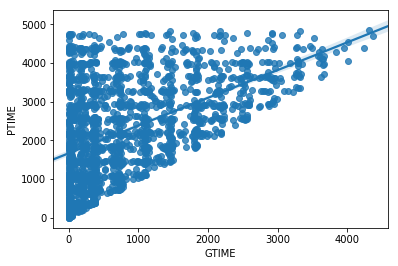

In [19]:
sns.regplot(x=sample["GTIME"], y=sample["PTIME"])

GTIME distribution

e:\anaconda\envs\default\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


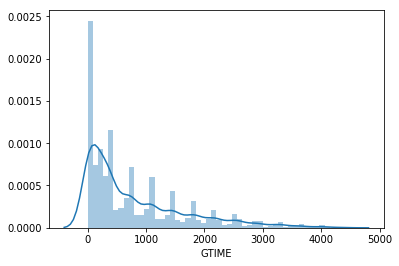

In [20]:
tmp=data[data.GSTATUS==1]
sns.distplot(tmp[tmp.GTIME.notnull()].GTIME)

Log(GTIME)

e:\anaconda\envs\default\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


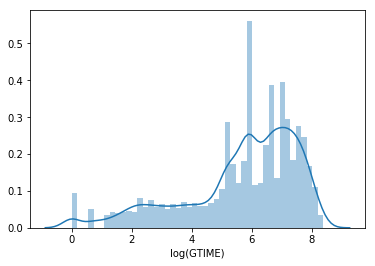

In [21]:
tmp=data[ (data.GSTATUS==1)].GTIME
tmp=tmp[tmp.notnull()]
tmp=tmp.map(lambda x: x+1)
tmp=np.log(tmp)
tmp.name="log(GTIME)"
sns.distplot(tmp)

e:\anaconda\envs\default\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


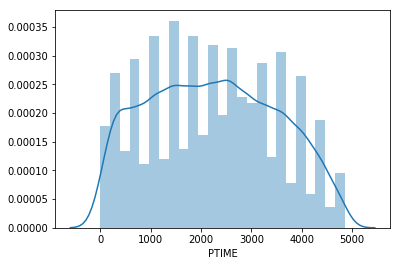

In [22]:
tmp=data[data.PSTATUS==1].PTIME
sns.distplot(tmp[tmp.notnull()])

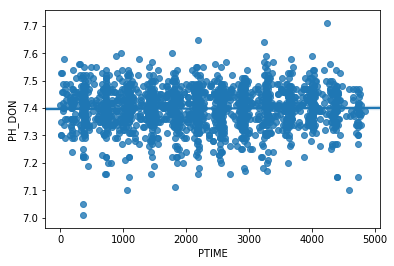

In [23]:
sns.regplot(x=sample["PTIME"], y=sample["PH_DON"])

Waitime

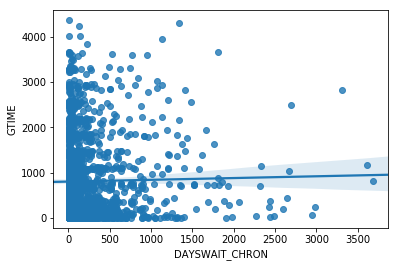

In [24]:
sns.regplot(x=sample["DAYSWAIT_CHRON"], y=sample["GTIME"])

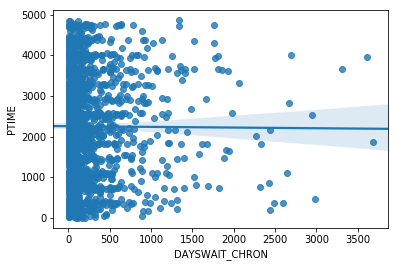

In [25]:
sns.regplot(x=sample["DAYSWAIT_CHRON"], y=sample["PTIME"])

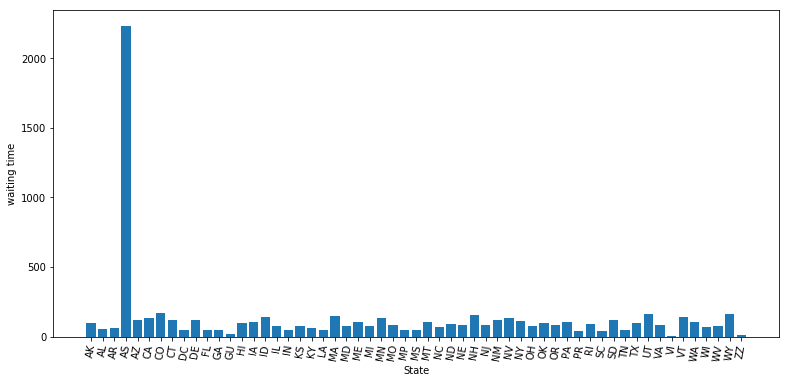

In [26]:
tmp=originalData.groupby(["PERM_STATE_TRR"])["PERM_STATE_TRR", "DAYSWAIT_CHRON"].median()
showBarChart(tmp.DAYSWAIT_CHRON, "State", "waiting time", tmp.index.values)

In [27]:
tmp=originalData.groupby(["ABO_MAT"])["ABO_MAT", "GTIME"].median()
tmp

,ABO_MAT,GTIME
ABO_MAT,,
1.0,1.0,396
2.0,2.0,400
3.0,3.0,385


In [28]:
tmp=originalData.groupby(["ABO_MAT"])["ABO_MAT", "PTIME"].median()
tmp

,ABO_MAT,PTIME
ABO_MAT,,
1.0,1.0,2190.0
2.0,2.0,2191.5
3.0,3.0,2191.0


In [29]:
tmp=originalData.groupby(["DIAG"])["DIAG", "GTIME"].median()
tmp

,DIAG,GTIME
DIAG,,
999,999.0,412.0
4100,4100.0,396.0
4101,4101.0,369.5
4102,4102.0,541.5
4104,4104.0,381.5
4105,4105.0,1856.0
4106,4106.0,353.0
4107,4107.0,1739.0
4108,4108.0,392.0


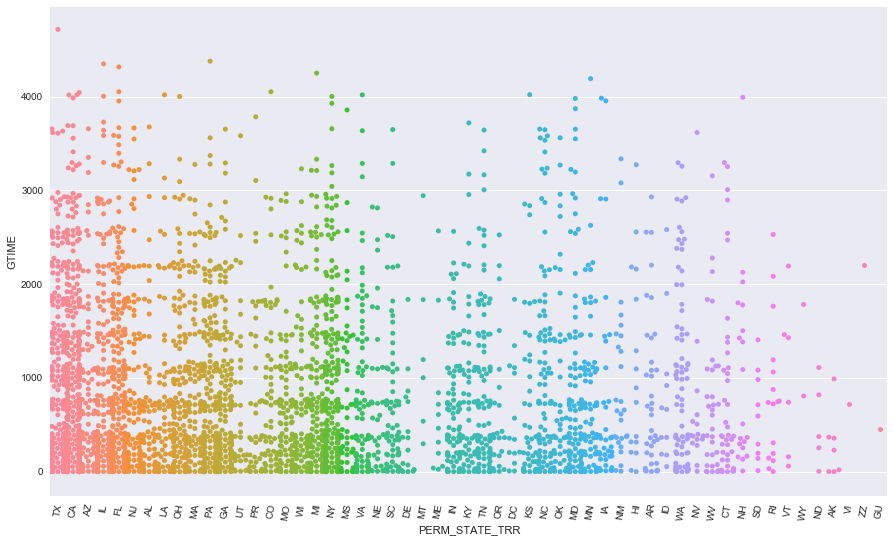

In [30]:
sns.set(rc={'figure.figsize':(15,9)})
sample=originalData.sample(5000)
plt.xticks(rotation=80)
tmp=sns.swarmplot(x="PERM_STATE_TRR", y="GTIME", data=sample)

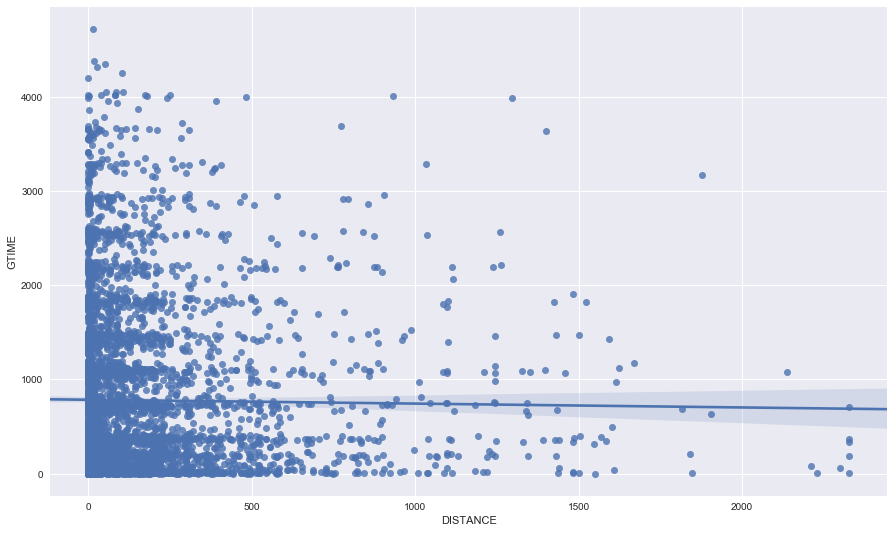

In [31]:
sns.regplot(x=sample.DISTANCE, y=sample.GTIME)

## 3. XGBoost Modeling

In [32]:
#data.drop(columns=tooManyCategories, inplace=True)
data.drop(columns=["PERM_STATE", "PERM_STATE_TRR", "HOME_STATE_DON"],inplace=True)

In [33]:
x,y =getXandY(data, day=90, PorG="GTIME")

In [64]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.2, random_state=1)
dtrain=xgb.DMatrix(x_train, label=y_train)
dtest= xgb.DMatrix(x_test, label=y_test)

# xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
#             'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 0,
#             'eval_metric': ["auc", "error"], 'objective': 'binary:logistic'}
xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 0,
            'eval_metric': "auc", 'objective': 'binary:logistic', "scale_pos_weight": 1}
watchlist=[(dtest, "eval"), (dtrain, "train")]

model=xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)

[0]	eval-auc:0.604415	train-auc:0.648399
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 50 rounds.
[10]	eval-auc:0.610425	train-auc:0.760153
[20]	eval-auc:0.616658	train-auc:0.779854
[30]	eval-auc:0.632676	train-auc:0.790388
[40]	eval-auc:0.634583	train-auc:0.798815
[50]	eval-auc:0.627299	train-auc:0.812956
[59]	eval-auc:0.622111	train-auc:0.826217


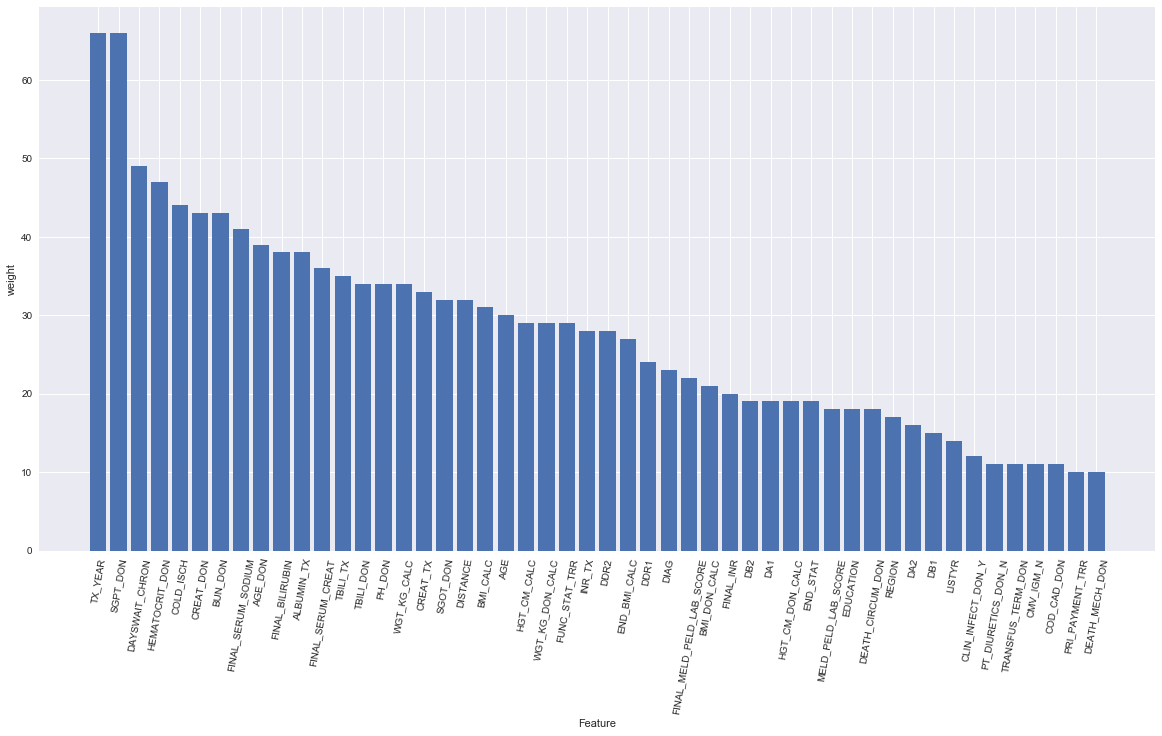

In [103]:
plotFeatureImportance(model, importanceType="weight", featureNum=50)

In [69]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 0,
            'eval_metric': "auc", 'objective': 'binary:logistic', "scale_pos_weight": 1}

dtrain=xgb.DMatrix(x_train, label=y_train)
xgb.cv(xgb_pars, dtrain, 60, nfold=5, seed=0, callbacks=[xgb.callback.print_evaluation(show_stdv=True)])


[0]	train-auc:0.55859+0.0173989	test-auc:0.520729+0.0120873
[1]	train-auc:0.598733+0.0307837	test-auc:0.539841+0.033447
[2]	train-auc:0.645061+0.0278621	test-auc:0.548812+0.0355054
[3]	train-auc:0.670852+0.0211395	test-auc:0.559044+0.0347923
[4]	train-auc:0.691684+0.0235382	test-auc:0.563189+0.0417379
[5]	train-auc:0.713448+0.0148881	test-auc:0.574132+0.036552
[6]	train-auc:0.729036+0.00788322	test-auc:0.572081+0.0280859
[7]	train-auc:0.745047+0.00984171	test-auc:0.58199+0.0134035
[8]	train-auc:0.753199+0.00980148	test-auc:0.582729+0.0128722
[9]	train-auc:0.762873+0.010584	test-auc:0.580312+0.0155813
[10]	train-auc:0.769118+0.00771818	test-auc:0.581607+0.0175262
[11]	train-auc:0.777649+0.0114159	test-auc:0.588215+0.0179996
[12]	train-auc:0.781545+0.0117866	test-auc:0.59128+0.0210708
[13]	train-auc:0.78488+0.0107096	test-auc:0.590638+0.0198176
[14]	train-auc:0.787771+0.00925036	test-auc:0.592959+0.0211951
[15]	train-auc:0.791249+0.00623951	test-auc:0.597052+0.0197344
[16]	train-auc:0.79

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.520729,0.012087,0.558590,0.017399
1,0.539841,0.033447,0.598733,0.030784
2,0.548812,0.035505,0.645061,0.027862
3,0.559044,0.034792,0.670852,0.021140
4,0.563189,0.041738,0.691684,0.023538
5,0.574132,0.036552,0.713448,0.014888
6,0.572081,0.028086,0.729036,0.007883
7,0.581990,0.013403,0.745047,0.009842
8,0.582729,0.012872,0.753199,0.009801
9,0.580312,0.015581,0.762873,0.010584


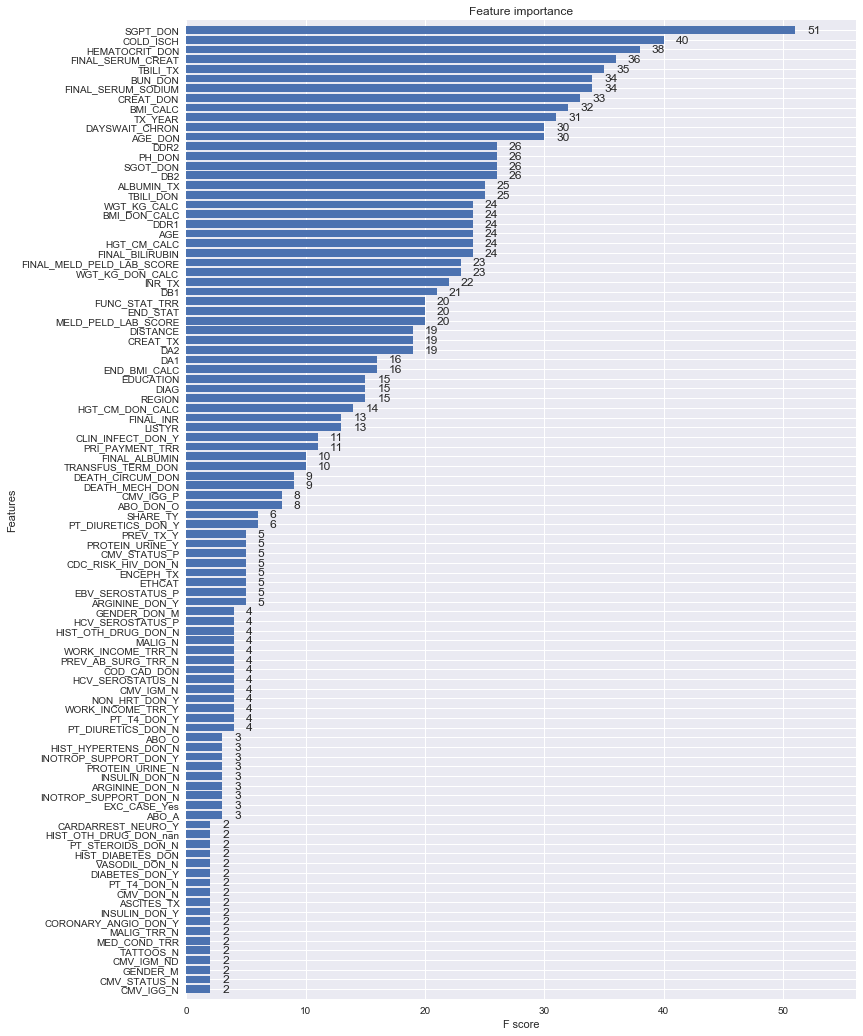

In [43]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
plt.show()

### 3.1 Feature Importance-based Feature Selection

In [110]:
importance=model.get_score( importance_type="weight")
kv=list(importance.items())
kv.sort(key=lambda x: -x[1])
tmp=list(zip(*kv))
names=tmp[0]
values=tmp[1]

In [118]:
newx=x.loc[ :, names]

In [124]:
x_train, x_test, y_train, y_test=train_test_split(newx,y, test_size=0.2, random_state=1)
dtrain=xgb.DMatrix(x_train, label=y_train)
dtest= xgb.DMatrix(x_test, label=y_test)

# xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
#             'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 0,
#             'eval_metric': ["auc", "error"], 'objective': 'binary:logistic'}
xgb_pars = {'min_child_weight': 50, 'eta': 0.02, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 0,
            'eval_metric': "auc", 'objective': 'binary:logistic', "scale_pos_weight": 1}
watchlist=[(dtest, "eval"), (dtrain, "train")]

model=xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=10)

[0]	eval-auc:0.514512	train-auc:0.542967
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 50 rounds.
[10]	eval-auc:0.586041	train-auc:0.691249
[20]	eval-auc:0.628363	train-auc:0.747096
[30]	eval-auc:0.625801	train-auc:0.774399
[40]	eval-auc:0.62353	train-auc:0.783812
[50]	eval-auc:0.625926	train-auc:0.805709
[59]	eval-auc:0.626153	train-auc:0.813005
